# Example of inter-operablity at Nice-Ligurian Testbed

**Add DOI**

Contributors: 
- Shane Murphy (Ifremer)
- Stijn Vermaere (VLIZ) 
- Sebastien Garziglia (Ifremer)
- Nikos Kalligeris (NOA)   


In this notebook we demonstrates how to download pressure and temperature data from a sensor located on the seafloor (black point in map) and compare it to the tide gauge data recorded at the coast (red point in map below) by examining the different time series collected between the 28 July 2024 and 1st August 2024.


<div style="text-align: center;">
    <img src="./Liguria_map_stations.png" alt="Station Map" width="600">
    <p><strong>Figure 1:</strong> Map showing the locations of the tide gauge (red) and piezometer sensor (black) in the Nice-Ligure region.</p>
</div>



## Import Required Libraries 

In [1]:
import requests
import pandas as pd
import xarray as xr
import numpy as np
import re

# libraries required for downloading Tide Gauge data
import pandas as pd
import math
import time
from datetime import datetime

# libraries required for piezometric data
import urllib.parse
from io import StringIO

# signal processing libraries
from scipy import signal


# graphics libraries
import matplotlib.pyplot as plt

### Functions used to download different datasets

In [20]:
# Downloader function for piezometric data from ERDDAP servers
# used to get data from EMSO ERDDAP server
#
def get_erddap_data(start, end, dataset_id, filetype="csv", timeout=60, verbose=False):
    """
    Robust ERDDAP tabledap subset downloader.

    Parameters
    ----------
    start, end : str
        ISO8601 timestamps, e.g. "2021-01-01T00:00:00Z"
    filetype : str
        "csv" or "nc"
    timeout : int
        HTTP request timeout in seconds
    verbose : bool
        Print constructed URL for debugging
    """

    server_url = "https://erddap.emso.eu/erddap/"
    variables = ["latitude","longitude","time", "depth", "SE_PRES", "SE_TEMP"]


    # sanitize server_url
    if not server_url.endswith("/"):
        server_url = server_url + "/"

    # normalize variables to list
    if isinstance(variables, str):
        variables = [v.strip() for v in variables.split(",") if v.strip()]
    if not variables:
        raise ValueError("`variables` must contain at least one variable name.")

    # optional: validate variable names against dataset info (helps catch typos)
    try:
        info_url = server_url + f"info/{dataset_id}/index.json"
        r_info = requests.get(info_url, timeout=20)
        r_info.raise_for_status()
        info = r_info.json()
        colnames = info['table']['columnNames']
        rows = info['table']['rows']
        df_info = pd.DataFrame(rows, columns=colnames)
        available_vars = df_info[df_info['Row Type'] == 'variable']['Variable Name'].tolist()
        missing = [v for v in variables if v not in available_vars]
        if missing:
            raise ValueError(
                f"Requested variables not present in dataset: {missing}\n"
                f"Available variables (sample): {available_vars[:30]}"
            )
    except requests.HTTPError as e:
        # can't fetch info — warn and continue (server may block info requests)
        if verbose:
            print("Warning: couldn't fetch dataset info:", e)
    except Exception as e:
        if verbose:
            print("Warning parsing dataset info:", e)

    # Build the safe URL:
    var_string = ",".join(variables)

    # Encode the timestamp values
    start_enc = urllib.parse.quote(start, safe="")
    end_enc   = urllib.parse.quote(end, safe="")

    # Encode comparison operators: >= -> %3E%3D  and  <= -> %3C%3D
    # This avoids illegal characters (<, >) in the URL.
    query = f"?{var_string}&time%3E%3D{start_enc}&time%3C%3D{end_enc}"
    url = f"{server_url}tabledap/{dataset_id}.{filetype}{query}"

    if verbose:
        print("Request URL (decoded):", urllib.parse.unquote(url))
        print("Request URL (encoded):", url)

    if filetype == "csv":
        r = requests.get(url, timeout=timeout)
        r.raise_for_status()
        return pd.read_csv(StringIO(r.text), skiprows=[1], low_memory=False)
    elif filetype == "nc":
        # xarray can open the encoded URL directly
        return xr.open_dataset(url)
    else:
        raise ValueError("Unsupported filetype: use 'csv' or 'nc'")
#
# Downsampling function for piezometric data
#
def downsample(subset_df,value):
    # Create an explicit copy to avoid the warning
    subset_df = subset_df.copy()
    subset_df['time'] = pd.to_datetime(subset_df['time'])

    # Sort by time to ensure proper ordering
    subset_df = subset_df.sort_values('time').reset_index(drop=True)

    # Calculate dt (sampling interval)
    dt = (subset_df['time'].iloc[1] - subset_df['time'].iloc[0]).total_seconds()
    print(f"Original sampling interval (dt): {dt} seconds")

    # Resample with averaging 
    # Set time as index first
    subset_df_indexed = subset_df.set_index('time')
    downsampled_df = subset_df_indexed.resample(value).mean()  # Resample to 10-second intervals
    downsampled_df = downsampled_df.reset_index()  # Reset index to get time back as column
    print(f"Downsampled interval (dt): {value}")
    return downsampled_df


#
# Function of extracting sea level data from IOC Sea Level Monitoring API
#
def get_sea_level_data(station_ID, sensor, includesensors, start_date, end_date, api_key, days_per_page=15, level_data='true'):
    """
    Fetch sea level data from the IOC Sea Level Monitoring API.
    Returns a pandas DataFrame with the sea level data.

    Parameters:
    station_ID : ID of the station, check:IOC Sea Level Monitoring website: https://www.ioc-sealevelmonitoring.org/map.php 
    sensor : "one-sensor" to retrieve one dataset, "alternate-sensor" to retrieve multiple sensors
    includesensors : list of sensors to include in the request, e.g. ["rad", "pr1", "pr2"]
    start_date : from date, included in result. Default is 8days in the past, "YYYY-MM-DD"
    end_date   : until date, not included in result. Default is day of request "YYYY-MM-DD"

    api_key : API key for authentication
    
    days_per_page : maximum number of days spanning a page, max 3650 days
    level_data : "true" to include level data, "false" to exclude it
    
    """
    api_url = "https://api.ioc-sealevelmonitoring.org/v2/research/stations/"
    
    original_stime = "false" # Return the stime not corrected by sensor rate.

    filter_out_of_range = "true" # Remove out of range values
    filter_exceeded_neighbours = "true" # Remove exceeded neighbour values
    filter_spikes_via_median = "true" # Remove spikes via median values
    filter_flat_line = "true" # Remove flat line
    flag_qc =  "false" # exclude qc flags 
    media_type = "application/json"  # or "text/csv"

    # === CALCULATE PAGINATION ===
    no_of_days = (datetime.fromisoformat(end_date) - datetime.fromisoformat(start_date)).days
    no_of_pages = math.ceil(no_of_days / days_per_page)

    # === STORAGE ===
    all_data = []

    # === LOOP OVER PAGES ===
    for page in range(1, no_of_pages + 1):
        # Build URL
        url = (
            f"{api_url}{station_ID}/sensors/{sensor}/data"
            f"?days_per_page={days_per_page}"
            f"&page={page}"
            f"&timestart={start_date}"
            f"&timestop={end_date}"
            f"&level_data={level_data}"
            f"&original_stime={original_stime}"
            f"&filter_out_of_range={filter_out_of_range}"
            f"&filter_exceeded_neighbours={filter_exceeded_neighbours}"
            f"&filter_spikes_via_median={filter_spikes_via_median}"
            f"&filter_flat_line={filter_flat_line}"
            f"&flag_qc={flag_qc}"
        )

        if includesensors:
            for s in includesensors:
                url += f"&includesensors[]={s}"

        print(f"Downloading page {page}/{no_of_pages} in {media_type} format")

        # Request
        headers = {"X-Api-Key": api_key, "Accept": media_type}
        resp = requests.get(url, headers=headers, timeout=60)

        if resp.status_code != 200:
            raise RuntimeError(f"Error fetching page {page}: {resp.status_code} {resp.text}")

        if media_type == "application/json":
            data_json = resp.json()["data"]
            df = pd.DataFrame(data_json)
            if "stime" in df.columns:
                df["stime"] = pd.to_datetime(df["stime"], format="%Y-%m-%d %H:%M:%S", utc=True)
        else:  # CSV
            from io import StringIO
            df = pd.read_csv(StringIO(resp.text), skiprows=2)

        all_data.append(df)

        time.sleep(1)  # polite pause

    # === COMBINE ===
    if all_data:
        S = pd.concat(all_data, ignore_index=True)
    else:
        raise RuntimeError("No sea level data.")

    print(S.info())
    print(S.head())
    return S


## Download EMSO Piezometric Data
Pressure and temperature values have been recorded at 7 different depths ranging from 0.79m to 7.07m. The first and last sensor record the absolute pressure while all other sensors recorded differential fluid pressure in sediment pores relative to the water column pressure. More information about the data can be found at the [SEANOE Portal](https://www.seanoe.org/data/00851/96265/)

In [21]:

start = "2024-07-28T00:00:00Z"
end   = "2024-08-01T00:00:00Z"
dataset_id = "EMSO-LIGURE-NICE_MAR2-PZML-01_2021-2022"


df = get_erddap_data(start, end,dataset_id,filetype="csv", verbose=True)


Request URL (decoded): https://erddap.emso.eu/erddap/tabledap/EMSO-LIGURE-NICE_MAR2-PZML-01_2021-2022.csv?latitude,longitude,time,depth,SE_PRES,SE_TEMP&time>=2024-07-28T00:00:00Z&time<=2024-08-01T00:00:00Z
Request URL (encoded): https://erddap.emso.eu/erddap/tabledap/EMSO-LIGURE-NICE_MAR2-PZML-01_2021-2022.csv?latitude,longitude,time,depth,SE_PRES,SE_TEMP&time%3E%3D2024-07-28T00%3A00%3A00Z&time%3C%3D2024-08-01T00%3A00%3A00Z


In [4]:
df

,latitude,longitude,time,depth,SE_PRES,SE_TEMP
0,43.64325,7.217683,2024-07-28T00:01:00Z,0.79,21.272,20.56
1,43.64325,7.217683,2024-07-28T00:01:00Z,2.38,-0.003,18.55
2,43.64325,7.217683,2024-07-28T00:01:00Z,3.89,-0.019,17.96
3,43.64325,7.217683,2024-07-28T00:01:00Z,4.79,1.617,17.97
4,43.64325,7.217683,2024-07-28T00:01:00Z,5.49,1.824,18.04
...,...,...,...,...,...,...
13435,43.64325,7.217683,2024-07-31T23:58:00Z,3.89,-0.012,17.99
13436,43.64325,7.217683,2024-07-31T23:58:00Z,4.79,1.792,17.98
13437,43.64325,7.217683,2024-07-31T23:58:00Z,5.49,1.911,18.04
13438,43.64325,7.217683,2024-07-31T23:58:00Z,7.04,0.253,18.14


### Subset of piezometric data
Now we will look at the data recorded at a few different depths (e.g. : 0.79m, 2.38m and 4.79m ) and down sample the data averaging over 10min windows. 

In [6]:
# extract subsets at different depths
subset_df_abs = df[df["depth"]==0.79]
subset_df_2m = df[df["depth"]==2.38]
subset_df_4m = df[df["depth"]==4.79] 

In [7]:
# downsampled data at different depths
downsampled_df_abs= downsample(subset_df_abs,'10min')
downsampled_df_2m= downsample(subset_df_2m,'10min')
downsampled_df_4m= downsample(subset_df_4m,'10min')

Original sampling interval (dt): 180.0 seconds
Downsampled interval (dt): 10min
Original sampling interval (dt): 180.0 seconds
Downsampled interval (dt): 10min
Original sampling interval (dt): 180.0 seconds
Downsampled interval (dt): 10min


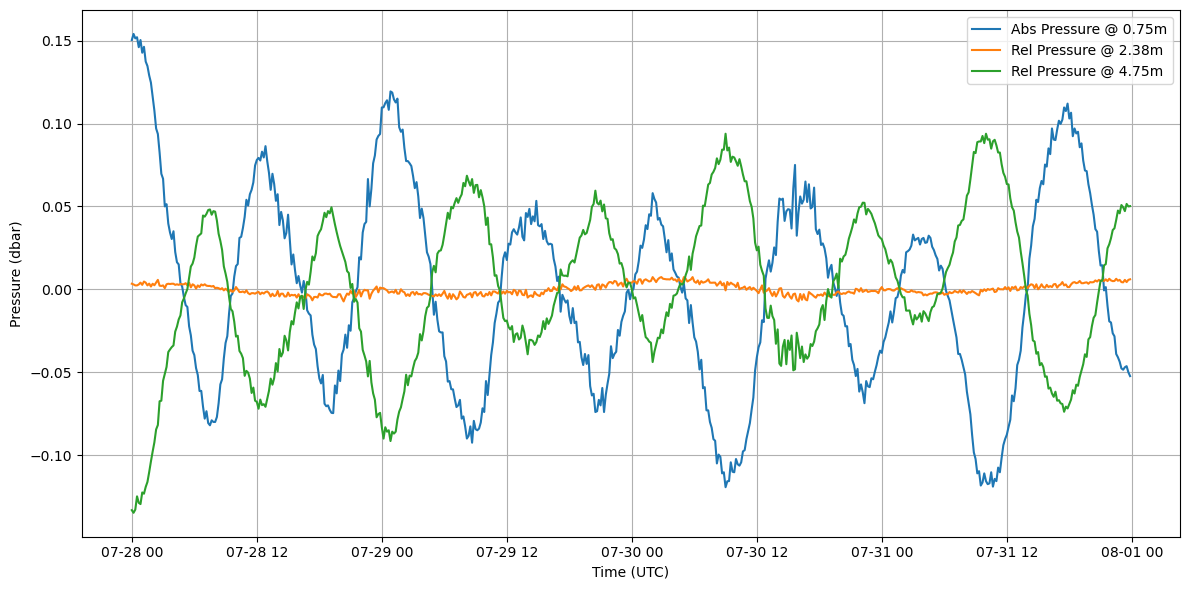

In [ ]:
# Plot the downsampled data
plt.figure(figsize=(12, 6))

plt.plot(downsampled_df_abs["time"], downsampled_df_abs["SE_PRES"]-downsampled_df_abs["SE_PRES"].mean(), label="Abs Pressure @ 0.75m")
plt.plot(downsampled_df_2m["time"], downsampled_df_2m["SE_PRES"]-downsampled_df_2m["SE_PRES"].mean(), label="Rel Pressure @ 2.38m")
plt.plot(downsampled_df_4m["time"], downsampled_df_4m["SE_PRES"]-downsampled_df_4m["SE_PRES"].mean(), label="Rel Pressure @ 4.75m")

plt.xlabel("Time (UTC)")
plt.ylabel("Pressure (dbar)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Tide Gauge data
Next we are going to download tide gauge data from the [Nice station](https://www.ioc-sealevelmonitoring.org/station.php?code=nice2) which is the closest to the piezometer station. Information on all the tide gauge stations available can be found on the [IOC Sea Level Monitoring website](https://www.ioc-sealevelmonitoring.org/map.php)

**Note**: an api key is required for downloading the tide gauge data directly through this notebook. To get an api key, you can register for free on the [IOC website](https://www.ioc-sealevelmonitoring.org/api_register.php)  

In [ ]:
# an api key is required, register at: , put key between quotes:
api_key="YOUR_API_KEY_HERE"

station_ID = "nice2"  # Station ID, this is the value for Nice Ligure, another close by station is Monaco "monc"
sensor = "alternate-sensor"    # "one-sensor" or "alternate-sensor"
includesensors = ["rad"]  # Replace with sensor type, e.g. "rad", "pr1", "pr2"

start_date = "2024-07-28"
end_date   = "2024-08-01"


S = get_sea_level_data(station_ID, sensor, includesensors, start_date, end_date,api_key)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5756 entries, 0 to 5755
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   slevel  5756 non-null   float64            
 1   stime   5756 non-null   datetime64[ns, UTC]
 2   sensor  5756 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 135.0+ KB
None
     slevel                     stime sensor
0  0.109554 2024-07-28 00:00:00+00:00    rad
1  0.108754 2024-07-28 00:01:00+00:00    rad
2  0.108654 2024-07-28 00:02:00+00:00    rad
3  0.108654 2024-07-28 00:03:00+00:00    rad
4  0.108654 2024-07-28 00:04:00+00:00    rad


In [11]:
# Looking at data format of data
S



,slevel,stime,sensor
0,0.109554,2024-07-28 00:00:00+00:00,rad
1,0.108754,2024-07-28 00:01:00+00:00,rad
2,0.108654,2024-07-28 00:02:00+00:00,rad
3,0.108654,2024-07-28 00:03:00+00:00,rad
4,0.108654,2024-07-28 00:04:00+00:00,rad
...,...,...,...
5751,-0.014209,2024-07-31 23:55:00+00:00,rad
5752,-0.015209,2024-07-31 23:56:00+00:00,rad
5753,-0.015209,2024-07-31 23:57:00+00:00,rad
5754,-0.014209,2024-07-31 23:58:00+00:00,rad


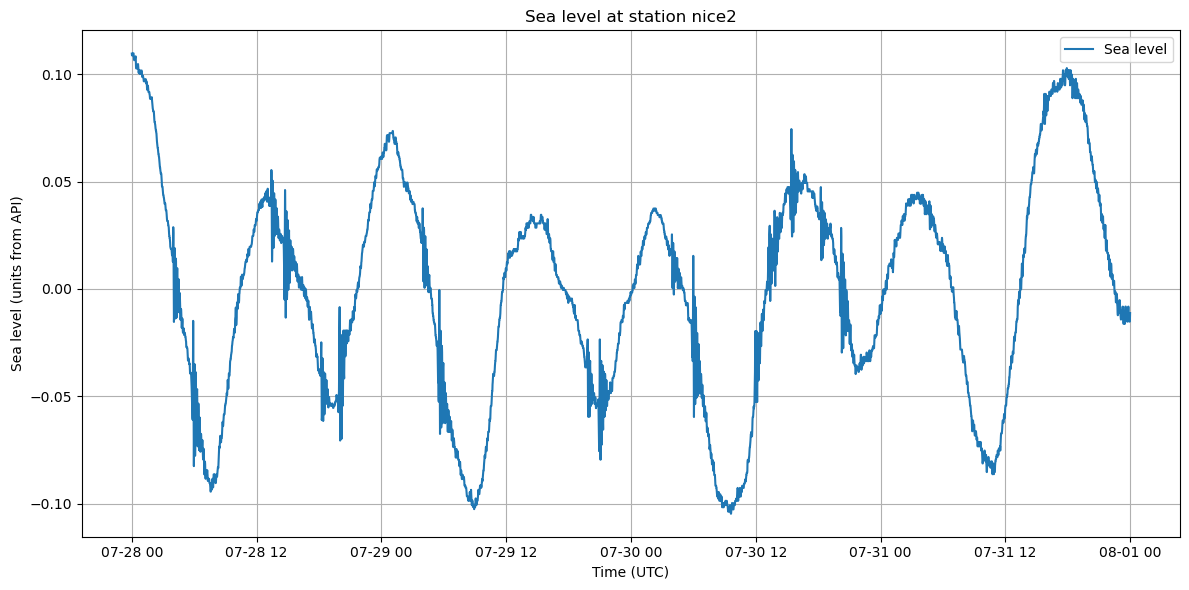

In [12]:
# Plot tide gauge data 
#
#  
plt.figure(figsize=(12, 6))
plt.plot(S["stime"], S["slevel"], label="Sea level")
plt.xlabel("Time (UTC)")
plt.ylabel("Sea level (units from API)")
plt.title(f"Sea level at station {station_ID}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Like the piezometer data we average the tide gauge data over a sampling period of 10 minutes

In [13]:
# Deterimine original sampling interval of tide gauge data
Stime = pd.to_datetime(S.stime)
dt = (Stime.iloc[1] - Stime.iloc[0]).total_seconds()
print(f"Original sampling interval (dt): {dt} seconds")

Original sampling interval (dt): 60.0 seconds


In [14]:
# Resample with averaging 
S_indexed = S.set_index('stime') # Set time as index first
Sealevel_df_downsampled = S_indexed.resample('10min').mean(numeric_only=True)
Sealevel_df_downsampled = Sealevel_df_downsampled.reset_index()  # Reset index to get time back as column

## Comparing the different datasets
As the different datasets cover different ranges, the mean value is taken away from each of them before plotting so that trends between them can be obseved  

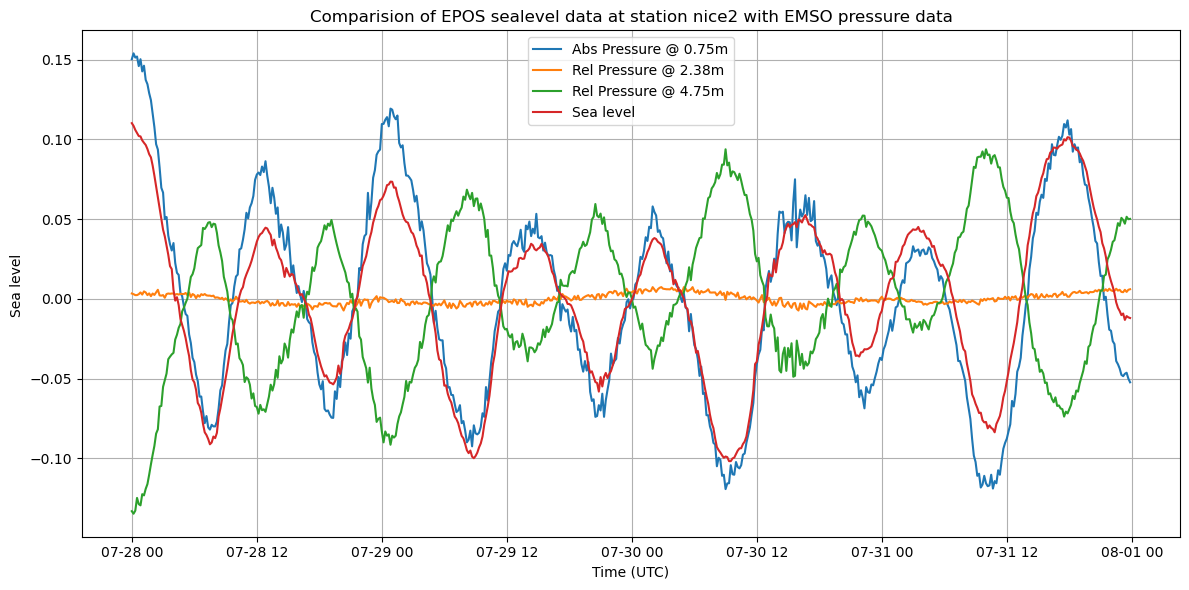

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(downsampled_df_abs["time"], downsampled_df_abs["SE_PRES"]-downsampled_df_abs["SE_PRES"].mean(), label="Abs Pressure @ 0.75m")
plt.plot(downsampled_df_2m["time"], downsampled_df_2m["SE_PRES"]-downsampled_df_2m["SE_PRES"].mean(), label="Rel Pressure @ 2.38m")
plt.plot(downsampled_df_4m["time"], downsampled_df_4m["SE_PRES"]-downsampled_df_4m["SE_PRES"].mean(), label="Rel Pressure @ 4.75m")
plt.plot(Sealevel_df_downsampled["stime"], Sealevel_df_downsampled["slevel"]-Sealevel_df_downsampled["slevel"].mean(), label="Sea level")

plt.xlabel("Time (UTC)")
plt.ylabel("Sea level ")
plt.title(f"Comparision of EPOS sealevel data at station {station_ID} with EMSO pressure data")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Futher analysis
If we want to check that the two time series are alinged we can calculate the cross correlation between them

In [16]:
def compute_cross_correlation(pressure, sealevel):
# First, ensure both series have the same length and no NaN values
# Remove NaN values
    pres_clean = pressure["SE_PRES"].dropna()
    slevel_clean = sealevel["slevel"].dropna()

# Make sure they're the same length (use the shorter length)
    min_len = min(len(pres_clean), len(slevel_clean))   
    pres_clean = pres_clean.iloc[:min_len]
    slevel_clean = slevel_clean.iloc[:min_len]

# Normalize the data (remove mean, divide by std)
    pres_norm = (pres_clean - pres_clean.mean()) / pres_clean.std()
    slevel_norm = (slevel_clean - slevel_clean.mean()) / slevel_clean.std()

# Compute cross-correlation
    correlation = signal.correlate(pres_norm, slevel_norm, mode='full')
    lags = signal.correlation_lags(len(pres_norm), len(slevel_norm), mode='full')

# Find the lag with maximum correlation
    max_corr_idx = np.argmax(correlation)
    best_lag = lags[max_corr_idx]
    max_corr_value = correlation[max_corr_idx] / len(pres_norm)  # Normalize
# normalise Correlation
    correlation = correlation / len(pres_norm)    

    print(f"Best lag: {best_lag} samples")
    print(f"Maximum correlation: {max_corr_value:.3f}")
    print(f"Time lag: {best_lag * 10} minutes")  # Since you resampled to minutes
    return best_lag, max_corr_value,lags,correlation

Best lag: 0 samples
Maximum correlation: 0.948
Time lag: 0 minutes


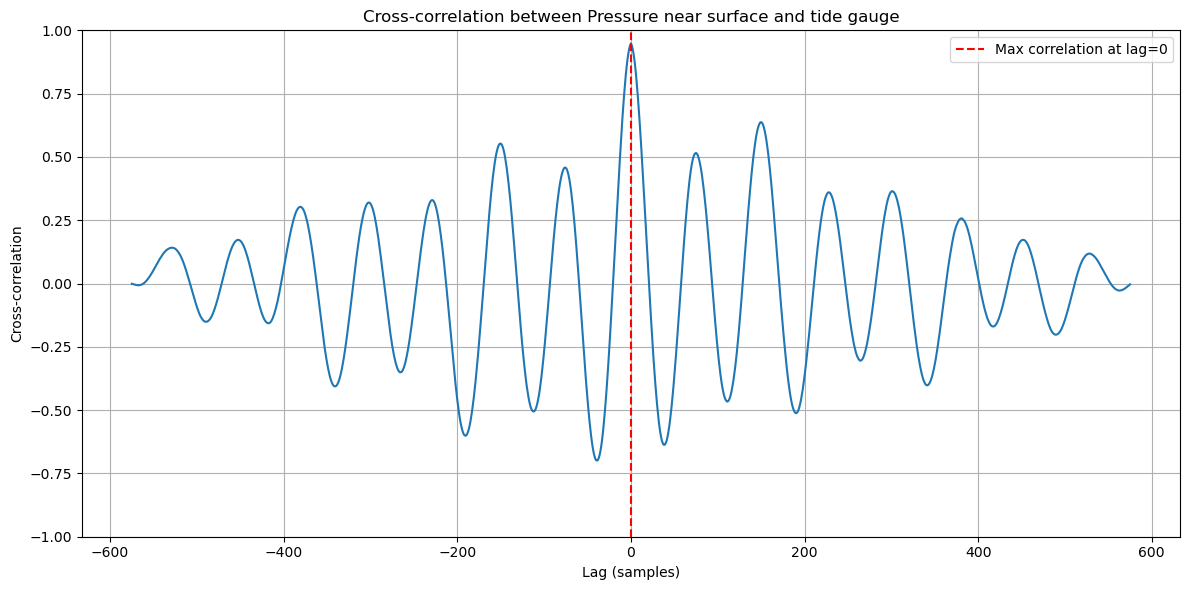

In [17]:
best_lag, max_corr_value, lags, correlation= compute_cross_correlation(downsampled_df_abs, Sealevel_df_downsampled)
# Plot the cross-correlation
plt.figure(figsize=(12, 6))
plt.plot(lags, correlation)
plt.axvline(best_lag, color='r', linestyle='--', label=f'Max correlation at lag={best_lag}')
plt.xlabel('Lag (samples)')
plt.ylabel('Cross-correlation')
plt.ylim(-1,1)
plt.title('Cross-correlation between Pressure near surface and tide gauge')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Best lag: 0 samples
Maximum correlation: 0.906
Time lag: 0 minutes


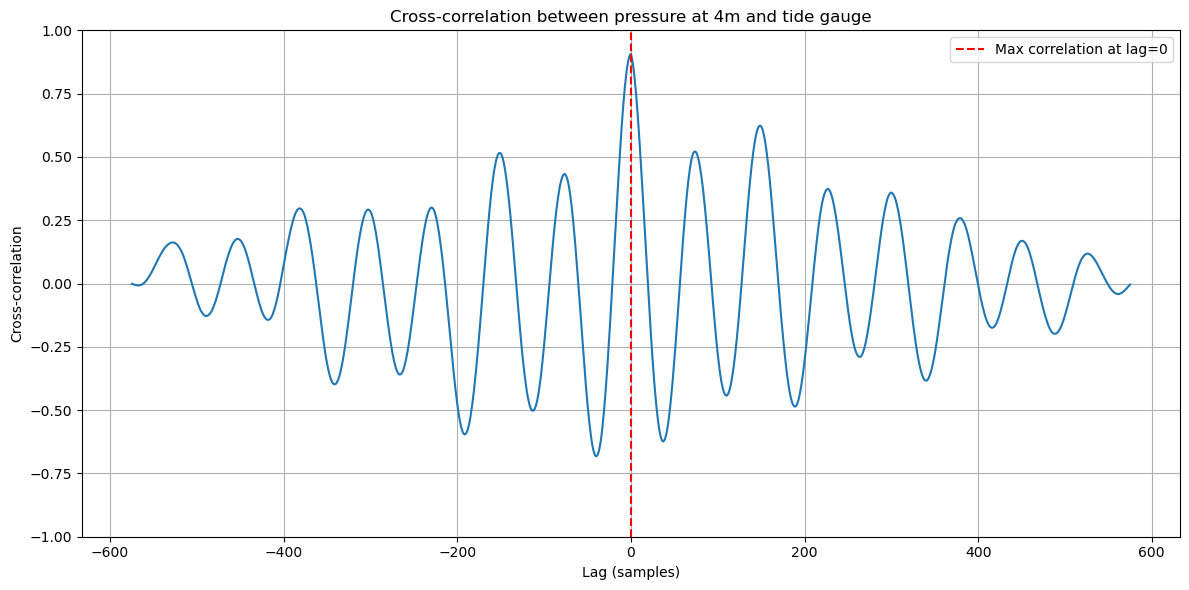

In [18]:
downsampled_df_4_neg = downsampled_df_4m.copy()
downsampled_df_4_neg['SE_PRES'] = -downsampled_df_4_neg['SE_PRES']
best_lag, max_corr_value, lags, correlation= compute_cross_correlation(downsampled_df_4_neg, Sealevel_df_downsampled)

# # Plot the cross-correlation
plt.figure(figsize=(12, 6))
plt.plot(lags, correlation)
plt.axvline(best_lag, color='r', linestyle='--', label=f'Max correlation at lag={best_lag}')
plt.ylim(-1,1)

plt.xlabel('Lag (samples)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between pressure at 4m and tide gauge')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Best lag: 225 samples
Maximum correlation: 0.192
Time lag: 2250 minutes


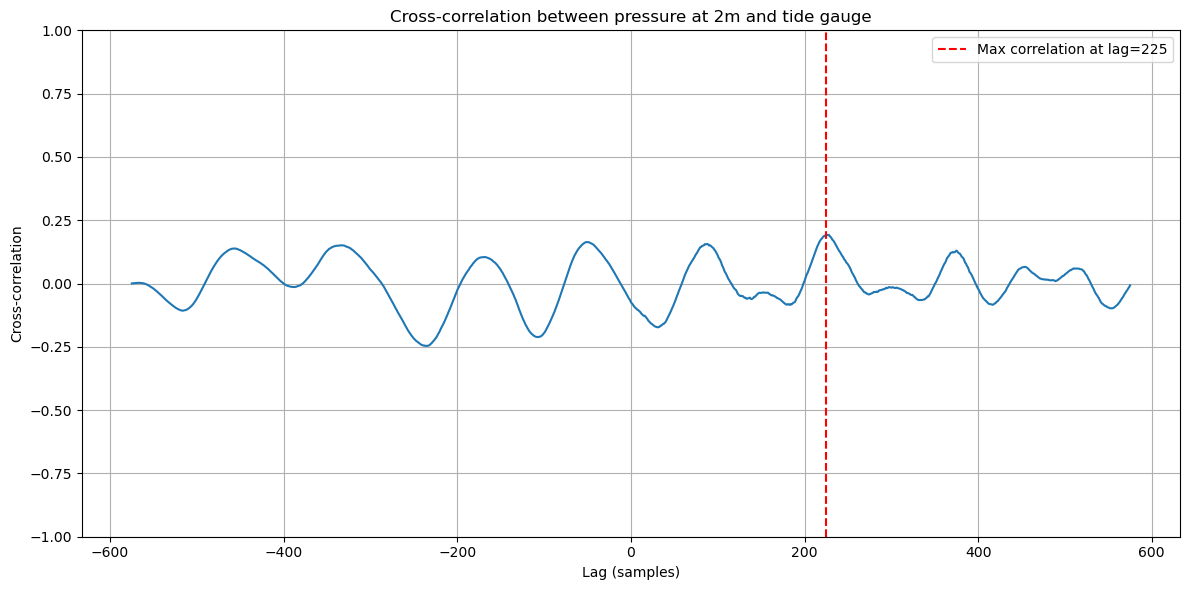

In [19]:
downsampled_df_2_neg = downsampled_df_2m.copy()
downsampled_df_2_neg['SE_PRES'] = -downsampled_df_2_neg['SE_PRES']
best_lag, max_corr_value, lags, correlation= compute_cross_correlation(downsampled_df_2_neg, Sealevel_df_downsampled)

# # Plot the cross-correlation
plt.figure(figsize=(12, 6))
plt.plot(lags, correlation)
plt.axvline(best_lag, color='r', linestyle='--', label=f'Max correlation at lag={best_lag}')
plt.ylim(-1,1)
plt.xlabel('Lag (samples)')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between pressure at 2m and tide gauge')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()